In [2]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [3]:
df = pd.read_csv('cepea.csv', encoding = 'latin1', sep = ';')

In [15]:
df

,Data,À vista R$,À vista US$,Dólar,Total_Geral_EXP,Total_EXP_Arabica,Preço Arabica CECAFE,Diferença (%) Preços
0,01/01/1997,"159,77","153,23","1,046",1447084,1.240.874,"128,91",-16%
1,01/02/1997,"194,62","185,54","1,051",1268427,1.076.394,"154,09",-17%
2,01/03/1997,"218,45","206,78","1,06",1739225,1.529.601,"185,17",-10%
3,01/04/1997,"224,07","211,25","1,064",1380063,1.197.325,"205,38",-3%
4,01/05/1997,"252,32","236,22","1,072",1565386,1.346.488,"214,94",-9%
...,...,...,...,...,...,...,...,...
336,01/01/2025,"2332,87","388,16","5,84",4005952,3.301.029,"343,63",-11%
337,01/02/2025,"2627,79","455,87","5,905",3420081,2.903.856,"375,24",-18%
338,01/03/2025,"2544,72","443,16","5,706",3296651,2.822.562,"416,70",-6%
339,01/04/2025,"2523,93","437,3","5,672",3103993,2.688.342,"449,50",3%


In [17]:
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
df['À vista R$'] = pd.to_numeric(df['À vista R$'].str.replace(',', '.'), errors='coerce')
df['À vista US$'] = pd.to_numeric(df['À vista US$'].str.replace(',', '.'), errors='coerce')

In [19]:
# Usando apenas a coluna alvo
serie = df["À vista US$"].astype('float64').values.reshape(-1, 1)

# Normalização
scaler = MinMaxScaler()
serie_normalizada = scaler.fit_transform(serie)

In [21]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        # Achata a janela: data[i:i+window_size].ravel()
        X.append(data[i:i+window_size].ravel())  
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [23]:
WINDOW_SIZE = 4
X, y = create_sequences(serie_normalizada, WINDOW_SIZE)

# Divisão treino/teste (ex: 80/20)
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [25]:
#mlp = MLPRegressor(hidden_layer_sizes=(25,), max_iter=6000, learning_rate = 'adaptive',
                   #solver='lbfgs', alpha=0.01, activation='tanh', random_state=8)

mlp = MLPRegressor(hidden_layer_sizes=(10,10), max_iter=2000, learning_rate = 'adaptive',
                   solver='lbfgs', alpha=0.01, activation='relu')

In [27]:
initreino = timer()
mlp.fit(X_train, y_train)
fimtreino = timer()

# Previsões
initeste = timer()
y_pred_train_scaled = mlp.predict(X_train)
y_pred_test_scaled = mlp.predict(X_test)
fimteste = timer()

# Inversão da escala
y_pred_train = scaler.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).ravel()
y_pred_test = scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).ravel()
y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Métricas
mae_train = mean_absolute_error(y_train_true, y_pred_train)
mae_test = mean_absolute_error(y_test_true, y_pred_test)
mape_train = np.mean(np.abs((y_train_true - y_pred_train) / y_train_true)) * 100
mape_test = np.mean(np.abs((y_test_true - y_pred_test) / y_test_true)) * 100
r2 = r2_score(y_test_true, y_pred_test)

D:\Documentos\Jupyter\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
print(f"Tempo de treino: {fimtreino - initreino:.2f} segundos")
print(f"Tempo de teste: {fimteste - initeste:.2f} segundos")
print(f"MAE treino: {mae_train:.2f}")
print(f"MAE teste: {mae_test:.2f}")
print(f"MAPE treino: {mape_train:.2f}%")
print(f"MAPE teste: {mape_test:.2f}%")
print(f"R² teste: {r2:.4f}")

Tempo de treino: 0.04 segundos
Tempo de teste: 0.00 segundos
MAE treino: 7.49
MAE teste: 10.14
MAPE treino: 5.97%
MAPE teste: 5.55%
R² teste: 0.9691


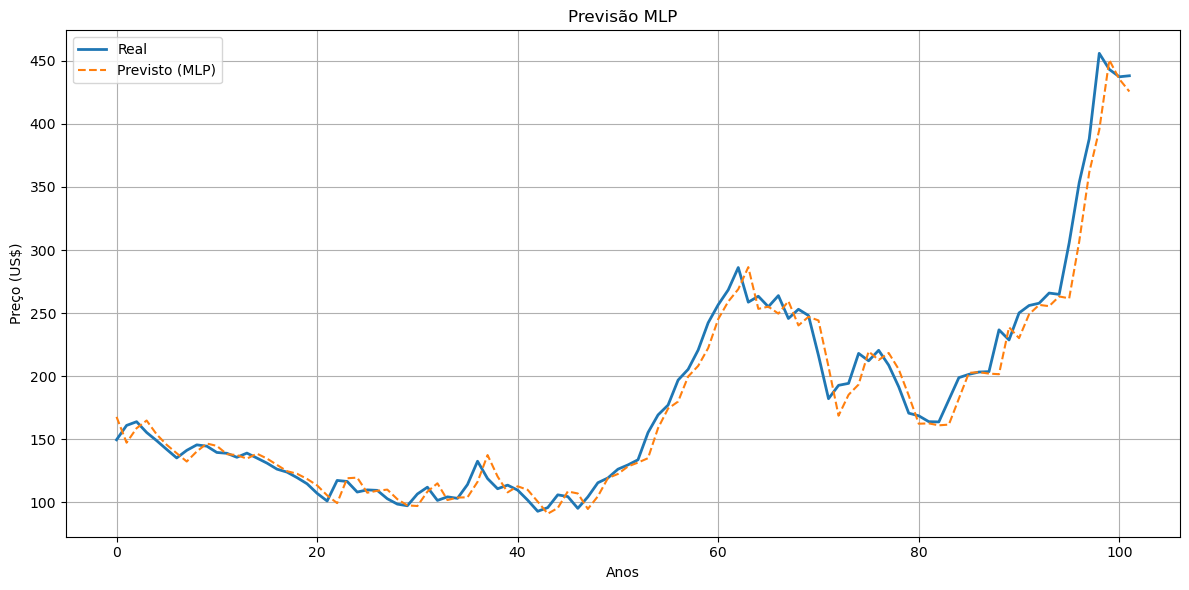

In [40]:
plt.figure(figsize=(12,6))
plt.plot(range(len(y_test_true)), y_test_true, label='Real', linewidth=2)
plt.plot(range(len(y_pred_test)), y_pred_test, label='Previsto (MLP)', linestyle='--')
plt.title("Previsão MLP")
plt.xlabel("Anos")
plt.ylabel("Preço (US$)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.savefig('preco_nlp.png')
plt.show()